In [10]:
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [11]:
df = pd.read_csv('./data/seoul-bike-data-clean-for-model.csv', encoding='unicode_escape')
X = df.drop('Rented Bike Count', axis=1)
y = df['Rented Bike Count']

X = X.select_dtypes(include=['float64', 'int64'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test

,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,Month,Year,WeekDay
6056,8,1.20,0.53,0.07,0.92,0.15,-0.13,-0.17,3,0,1,10,8,2018,5
5556,12,1.65,-0.35,0.36,-1.05,3.04,-0.13,-0.17,3,0,1,20,7,2018,5
5990,14,1.77,-0.40,-0.51,0.51,1.28,-0.13,-0.17,3,0,1,7,8,2018,2
7674,18,0.34,-0.55,-0.31,0.33,-0.53,-0.13,-0.17,4,0,1,16,10,2018,2
3319,7,-0.54,-0.35,-0.70,-0.06,-0.44,-0.13,-0.17,2,0,1,18,4,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,3,-0.69,0.33,-1.57,0.93,-0.66,-0.13,-0.17,4,0,1,12,11,2018,1
100,4,-1.68,-1.19,1.23,0.93,-0.66,-0.13,-0.17,1,0,1,5,12,2017,2
6605,5,0.65,0.33,-0.60,0.93,-0.66,-0.13,-0.17,4,0,1,2,9,2018,7
1783,7,-1.68,0.58,0.17,0.84,-0.66,-0.13,-0.17,1,0,1,13,2,2018,2


In [12]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models2, predictions2 = clf.fit(X_train, X_test, y_train, y_test)
print(models2)

100%|██████████| 42/42 [00:39<00:00,  1.07it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 15
[LightGBM] [Info] Start training from score 0.000257
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.94       0.94  0.24        0.49
LGBMRegressor                                0.94       0.94  0.24        0.11
ExtraTreesRegressor                          0.94       0.94  0.24        4.07
XGBRegressor                                 0.94       0.94  0.25        0.22
RandomForestRegressor                        0.93       0.93  0.27        8.01
BaggingRegressor                          

Now that we have our data, we can start building our model. We will use the `RandomForestRegressor` from `sklearn` to train our model. We will use GridSearchCV in order to find the best parameters for our model.

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': range(1,10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, scoring='r2')

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
Best parameters: {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Now that we have our best parameters, we can train our model using these parameters.

In [14]:
model = RandomForestRegressor(**best_params, random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200,
                      random_state=42)

Now that we have trained our model, we can make predictions on the test set and evaluate the model.

In [15]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.08255609946587276
Mean Absolute Error: 0.1740232928362238
R^2 Score: 0.9175770526251155


The r² score of 0.92 indicates that our model is a good fit for the data. Let's plot the predictions vs actual to get a better idea of how our model is performing.

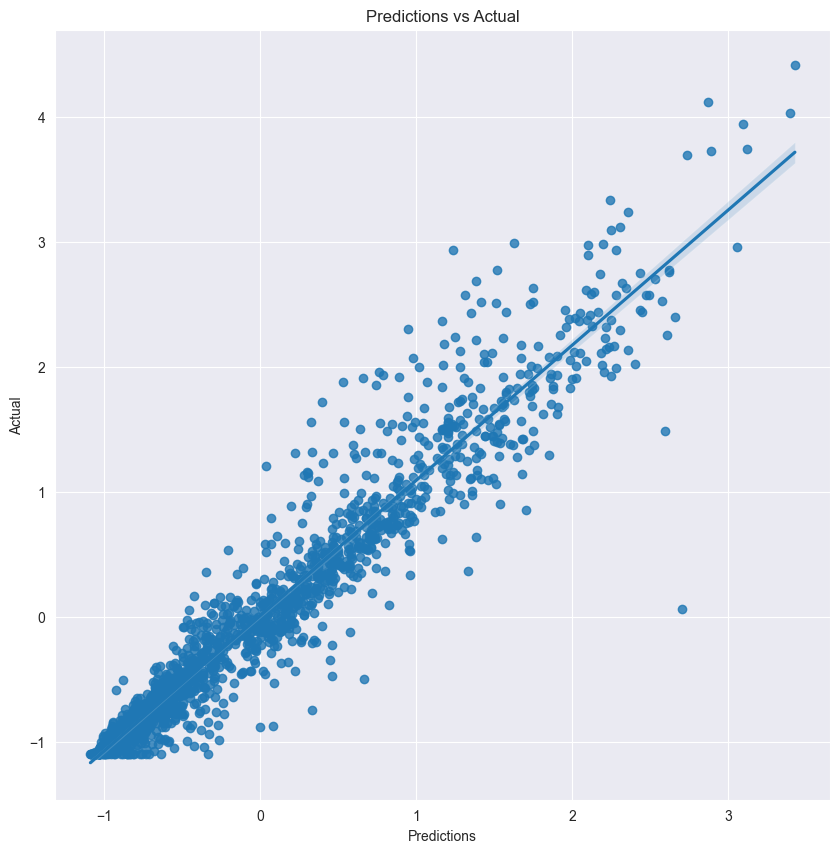

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.regplot(x=predictions, y=y_test, fit_reg=True)
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.show()

We see that our model is doing a good job of predicting the target variable apart from a few points. Let's plot the feature importance to see which features are the most important.

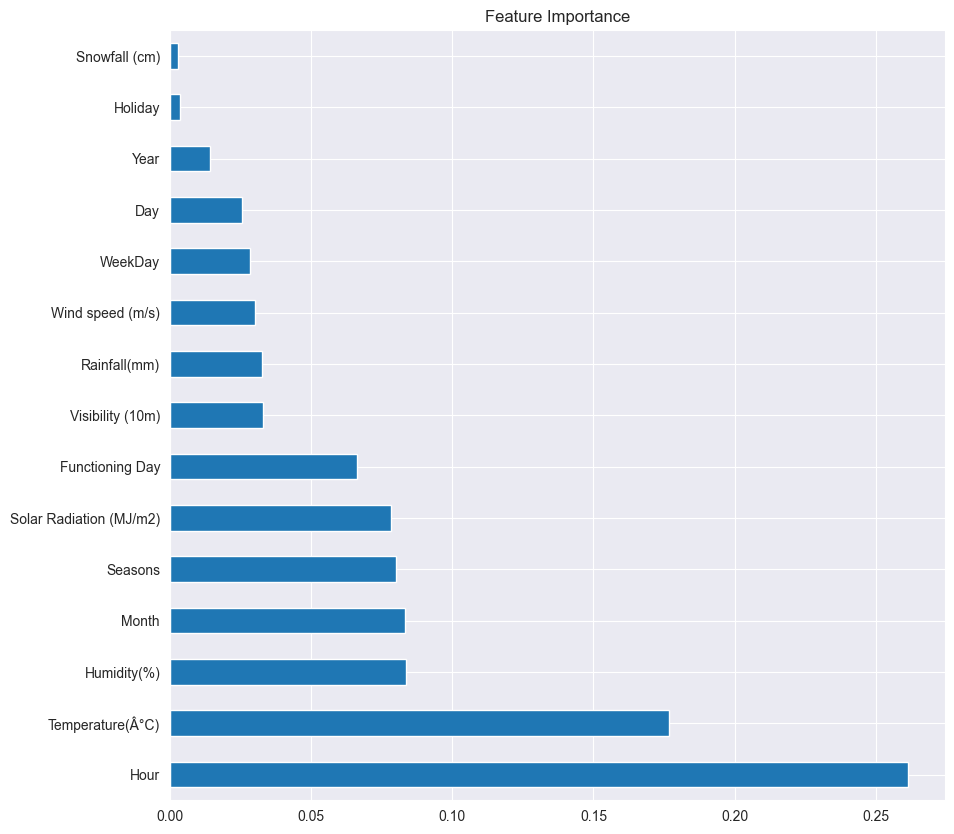

In [17]:
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

We see that the `Hour` feature is the most important feature. This makes sense as the number of bikes rented will depend on the hour of the day. The `Temperature` feature is also important as the number of persons who rent a bike will depend on the temperature.The `Month` and `Seasons`are also important features as the weather conditions generally depends on the month and season.

In [18]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

We save our model for our web app. We will use this model to make predictions on the web app.